# Task 2: PTBDB: Shallow Neural Network with Short-Time Fourier Transform on Data

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
#import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import optimizers, losses, activations, models
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, SimpleRNN, Input, LSTM, Layer, Flatten
from keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.signal import stft
from matplotlib import pyplot as plt



In [7]:
#gpu setup when using Tensorflow to address memory expansion/growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Read in data and split into train and test sets.

In [8]:
#read in data and split, from baseline
df_1 = pd.read_csv("../01-Data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("../01-Data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train_pre, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187], shuffle=True)

Y = np.array(df_train_pre[187].values).astype(np.int8)
X = np.array(df_train_pre[list(range(187))].values)

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)


Define the function to get the model.

The model gets the input and then the short-time fourier transform is applied to the input. This can be seen as a kind of feature engineering step. The input given is the raw signal (no normalization has been done on the data). 

The network of the model is very shallow, with two separate hidden layers which handle the real and imaginary parts of the fourier transform result,and one output layer combining the outputs of the two hidden layers. 

This function is for hyperparameter tuning.

In [4]:
def get_tuning_model(hp):
    nclass = 1
    inp = Input(shape=(187,))
    frame_length = hp.Int("frame_length", min_value=25, max_value=35, step=2)
    reg_val = hp.Choice("regularizer", values=[0.0, 0.01])
    reg = tf.keras.regularizers.l1(l1=reg_val)
    coeff1 = stft(
            inp, 
            frame_length= frame_length,
            frame_step=hp.Int("frame_step", min_value=2, max_value=10, step=2), 
            pad_end=True
            )

    dense_1 = Dense(hp.Int("dense_units", min_value=30, max_value=60, step=5), activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_1")(tf.math.real(coeff1))
    #dense_11 = Dense(5, activation=activations.relu, name="dense_11")(dense_1)
    dense_2 = Dense(hp.Int("dense_units", min_value=30, max_value=60, step=5), activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_2")(tf.math.imag(coeff1))
    #dense_21 = Dense(5, activation=activations.relu, name="dense_21")(dense_2)
    flatten = Flatten()(tf.concat([dense_1, dense_2], 1))
    dense_3 = Dense(nclass, name="dense_3_ptbdb")(flatten)

    model = models.Model(inputs=inp, outputs=dense_3)
    opt = optimizers.Adadelta(1)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model


Perform hypertuning to find best frame_length and frame_step for stft.
WARNING: running the tuner may take a long time!! 

In [ ]:
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)

X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1337, shuffle=True)

tuner = Hyperband(
	get_tuning_model, 
	objective="val_acc",
	max_epochs=250,
	factor=10,
	hyperband_iterations=2,
	seed=42
	)

tuner.search_space_summary()

tuner.search(
	x=X, y=Y, 
	validation_data=(X_val, Y_val), 
	callbacks=[early],
	epochs=250
	)

bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number for frame_length: {}".format(
	bestHP.get("frame_length")))
print("[INFO] optimal number for frame_step: {}".format(
	bestHP.get("frame_step")))
print("[INFO] optimal number of units in dense layer: {}".format(
	bestHP.get("dense_units")))

X = np.concatenate((X,X_val))
Y = np.concatenate((Y,Y_val))

best_model = tuner.get_best_models(num_models=1)
best_model[0].save_weights('./stft_ptbdb-BestTunedModel.h5')

Best value for frame_length: 33

Best value for regularizer: 0

Best value for frame_step: 6

Best value for dense units: 55

Define function that returns a model based on user inputs (not used for tuning).

In [9]:
def get_model(fl, fs, reg, units):
    nclass = 1
    inp = Input(shape=(187,))
    reg = tf.keras.regularizers.l1(l1=reg)
    coeff1 = stft(
            inp, 
            frame_length= fl,
            frame_step=fs, 
            pad_end=True
            )

    dense_1 = Dense(units, activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_1")(tf.math.real(coeff1))
    #dense_11 = Dense(5, activation=activations.relu, name="dense_11")(dense_1)
    dense_2 = Dense(units, activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_2")(tf.math.imag(coeff1))
    #dense_21 = Dense(5, activation=activations.relu, name="dense_21")(dense_2)
    flatten = Flatten()(tf.concat([dense_1, dense_2], 1))
    dense_3 = Dense(nclass, name="dense_3_ptbdb")(flatten)

    model = models.Model(inputs=inp, outputs=dense_3)
    opt = optimizers.Adadelta(1)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

Train the model with the train data set.

In [10]:
m = get_model(33, 6, 0, 55)
m.fit(X, Y, epochs=200, verbose=2, shuffle=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187)]        0           []                               
                                                                                                  
 tf.signal.stft_1 (TFOpLambda)  (None, 32, 33)       0           ['input_2[0][0]']                
                                                                                                  
 tf.math.real_1 (TFOpLambda)    (None, 32, 33)       0           ['tf.signal.stft_1[0][0]']       
                                                                                                  
 tf.math.imag_1 (TFOpLambda)    (None, 32, 33)       0           ['tf.signal.stft_1[0][0]']       
                                                                                            

Do prediction on the test set.  
Print out f1 and accuracy score.

Test f1 score : 0.9839015151515151 
Test accuracy score : 0.9766403297835795 
Test AUROC score :  0.9670970845354181 
Test AUPRC score :  0.9763284842753042 


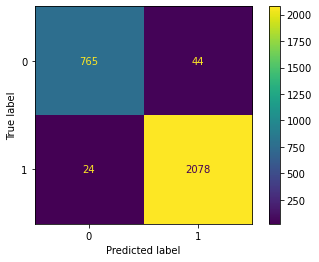

In [11]:
predicted_labels = m.predict(X_test)
predicted_labels = (predicted_labels>0.5).astype(np.int8)
#prediction scores

f1 = f1_score(Y_test, predicted_labels)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, predicted_labels)

print("Test accuracy score : %s "% acc)

auroc = roc_auc_score(Y_test, predicted_labels)

print("Test AUROC score :  %s "% auroc)

auprc = average_precision_score(Y_test, predicted_labels)

print("Test AUPRC score :  %s "% auprc)

cm =  confusion_matrix(Y_test, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
